In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
import numpy as np
import vice
import sys
# from databanks.SDSS.IPL3 import IPL3_GIANTS
from databanks.SDSS.DR19 import ASPCAP_GIANTS as DR19GIANTS
sys.path.append("..")
from src.utils import subsample_stellar_populations, get_velocity_profile, oh_to_12pluslog
from src.plots.utils import weighted_median
load_style_sheet("papers")
print(sys.version_info)
# IPL3_GIANTS = vice.dataframe(IPL3_GIANTS)
DR19GIANTS = vice.dataframe(DR19GIANTS)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [2]:
# IPL3_GIANTS["mg_fe"] = [mg - fe for mg, fe in zip(IPL3_GIANTS["mg_h"], IPL3_GIANTS["fe_h"])]
# IPL3_GIANTS["absz"] = [abs(z) for z in IPL3_GIANTS["z"]]
DR19GIANTS["mg_fe"] = [mg - fe for mg, fe in zip(DR19GIANTS["mg_h"], DR19GIANTS["fe_h"])]
DR19GIANTS["absz"] = [abs(z) for z in DR19GIANTS["z"]]

In [3]:
# output = vice.output("../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8")
# extra = np.genfromtxt("%s_analogdata.out" % (output.name))
# output.stars["absz"] = [abs(_) for _ in extra[:,-1][:output.stars.size[0]]]
outputs = [
    "../outputs/expifr/amd/base",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin+0p8",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8"
]
outputs = [vice.output(name) for name in outputs]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:,-1][:out.stars.size[0]]]

In [4]:
def alpha_separation(feh):
    if feh < -1:
        return alpha_separation(-1)
    elif -1 <= feh <= 0:
        return 0.12 - 0.13 * feh
    else:
        return 0.12

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_3909/2821623205.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


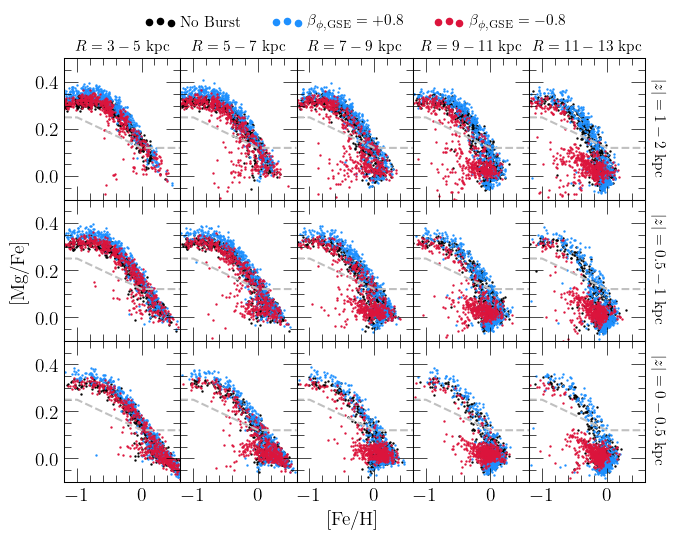

In [7]:
COLORS = ["black", "dodgerblue", "crimson"]
RADII = [[3, 5], [5, 7], [7, 9], [9, 11], [11, 13]]
ZHEIGHTS = [[1, 2], [0.5, 1], [0, 0.5]] # backwards to put high |z| at the top
LABELS = ["No Burst", r"$\beta_{\phi,\text{GSE}} = +0.8$", r"$\beta_{\phi,\text{GSE}} = -0.8$"]
FEH_ERR = 0.0087
MGFE_ERR = 0.017

fig, axes = plt.subplots(nrows = len(ZHEIGHTS), ncols = len(RADII), figsize = (7.5, 5.5), sharex = True, sharey = True)
axes[0][0].set_xlim([-1.2, 0.6])
axes[0][0].set_ylim([-0.1, 0.5])
axes[2][2].set_xlabel(r"[Fe/H]")
axes[1][0].set_ylabel(r"[Mg/Fe]")
for i in range(len(RADII)):
    axes[0][i].set_title(r"$R = %d - %d$ kpc" % (RADII[i][0], RADII[i][1]), fontsize = 11)
for i in range(len(ZHEIGHTS)):
    axes[i][-1].yaxis.set_label_position("right")
    axes[i][-1].set_ylabel(r"$\left|z\right| = %g - %g$ kpc" % (ZHEIGHTS[i][0], ZHEIGHTS[i][1]),
        fontsize = 11, rotation = 270, labelpad = 15)

def plot_stars(ax, output, rmin, rmax, abszmin, abszmax, zone_width = 0.1, N = 500, seed = 0, **kwargs):
    stars = output.stars.filter(
        "zone_final", ">=", int(rmin / zone_width)).filter(
        "zone_final", "<=", int(rmax / zone_width) - 1).filter(
        "absz", ">=", abszmin).filter(
        "absz", "<=", abszmax).filter(
        "[fe/h]", ">=", ax.get_xlim()[0]).filter(
        "[fe/h]", "<=", ax.get_xlim()[1]).filter(
        "[mg/fe]", ">=", ax.get_ylim()[0]).filter(
        "[mg/fe]", "<=", ax.get_ylim()[1]).filter(
        "mass", ">", 1)
    stars = subsample_stellar_populations(stars, N = N, seed = seed)
    err_feh = np.random.normal(scale = FEH_ERR, size = N)
    err_mgfe = np.random.normal(scale = MGFE_ERR, size = N)
    for i in range(N):
        stars["[fe/h]"][i] += err_feh[i]
        stars["[mg/fe]"][i] += err_mgfe[i]
    ax.scatter(stars["[fe/h]"], stars["[mg/fe]"], **kwargs)

for i in range(len(outputs)):
    for j in range(len(RADII)):
        for k in range(len(ZHEIGHTS)):
            kwargs = {
                "s": 0.5,
                "c": named_colors()[COLORS[i]],
                "rasterized": True,
                "label": LABELS[i]
            }
            plot_stars(axes[k][j], outputs[i], *RADII[j], *ZHEIGHTS[k], **kwargs)

xvals = np.linspace(axes[0][0].get_xlim()[0], axes[0][0].get_xlim()[1], 1000)
yvals = [alpha_separation(feh) for feh in xvals]
for j in range(len(RADII)):
    for k in range(len(ZHEIGHTS)):
        axes[k][j].plot(xvals, yvals, c = named_colors()["silver"], linestyle = "--")

kwargs = {
    "loc": mpl_loc("lower center"),
    "bbox_to_anchor": (0.5, 1.1),
    "ncol": 3,
    "handlelength": 2,
    "fontsize": 11
}
leg = axes[0][2].legend(**kwargs)
for i in range(len(leg.legend_handles)):
    leg.legend_handles[i]._sizes = [20]
# fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0)
# for ext in ["pdf", "jpeg"]:
#     kwargs = {}
#     if ext == "jpeg": kwargs["dpi"] = 200
#     plt.savefig("./afe-feh/galactic-regions-prograde-vs-retrograde.%s" % (ext), **kwargs)
plt.show()

In [3]:
# output = vice.output("../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8")
# extra = np.genfromtxt("%s_analogdata.out" % (output.name))
# output.stars["absz"] = [abs(_) for _ in extra[:,-1][:output.stars.size[0]]]
outputs = [
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin+0p8-highres",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8-highres"
    # "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin+0p8-highsigmacrit",
    # "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8-highsigmacrit",
    # "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin+0p8-nohalo",
    # "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8-nohalo",
]
outputs = [vice.output(name) for name in outputs]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:,-1][:out.stars.size[0]]]

j = 4 ; k = 2    


/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_57099/3864080983.py:111: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


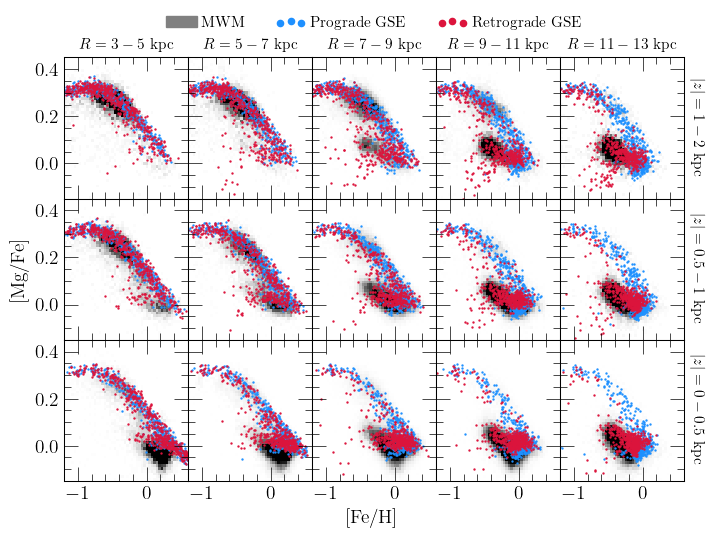

In [4]:
# COLORS = ["black", "dodgerblue", "crimson"]
COLORS = ["dodgerblue", "crimson"]
RADII = [[3, 5], [5, 7], [7, 9], [9, 11], [11, 13]]
ZHEIGHTS = [[1, 2], [0.5, 1], [0, 0.5]] # backwards to put high |z| at the top
# LABELS = ["No Burst", r"$\beta_{\phi,\text{GSE}} = +0.8$", r"$\beta_{\phi,\text{GSE}} = -0.8$"]
# LABELS = [r"$\beta_{\phi,\text{GSE}} = +0.8$", r"$\beta_{\phi,\text{GSE}} = -0.8$"]
LABELS = ["Prograde GSE", "Retrograde GSE"]
FEH_ERR = 0.0087
MGFE_ERR = 0.017

fig, axes = plt.subplots(nrows = len(ZHEIGHTS), ncols = len(RADII), figsize = (8, 5.5), sharex = True, sharey = True)
axes[0][0].set_xlim([-1.2, 0.6])
axes[0][0].set_ylim([-0.15, 0.45])
axes[2][2].set_xlabel(r"[Fe/H]")
axes[1][0].set_ylabel(r"[Mg/Fe]")
for i in range(len(RADII)):
    axes[0][i].set_title(r"$R = %d - %d$ kpc" % (RADII[i][0], RADII[i][1]), fontsize = 11)
for i in range(len(ZHEIGHTS)):
    axes[i][-1].yaxis.set_label_position("right")
    axes[i][-1].set_ylabel(r"$\left|z\right| = %g - %g$ kpc" % (ZHEIGHTS[i][0], ZHEIGHTS[i][1]),
        fontsize = 11, rotation = 270, labelpad = 15)

def plot_stars(ax, output, rmin, rmax, abszmin, abszmax, zone_width = 0.1, N = 500, seed = 0, **kwargs):
    stars = output.stars.filter(
        "zone_final", ">=", int(rmin / zone_width)).filter(
        "zone_final", "<=", int(rmax / zone_width) - 1).filter(
        "absz", ">=", abszmin).filter(
        "absz", "<=", abszmax).filter(
        "[fe/h]", ">=", ax.get_xlim()[0]).filter(
        "[fe/h]", "<=", ax.get_xlim()[1]).filter(
        "[mg/fe]", ">=", ax.get_ylim()[0]).filter(
        "[mg/fe]", "<=", ax.get_ylim()[1]).filter(
        "mass", ">", 1)
    stars = subsample_stellar_populations(stars, N = N, seed = seed)
    err_feh = np.random.normal(scale = FEH_ERR, size = N)
    err_mgfe = np.random.normal(scale = MGFE_ERR, size = N)
    for i in range(N):
        stars["[fe/h]"][i] += err_feh[i]
        stars["[mg/fe]"][i] += err_mgfe[i]
    return ax.scatter(stars["[fe/h]"], stars["[mg/fe]"], **kwargs)

def plot_data(ax, rmin, rmax, abszmin, abszmax, **kwargs):
    # stars = IPL3_GIANTS.filter(
    stars = DR19GIANTS.filter(
        "rgal", ">=", rmin).filter(
        "rgal", "<=", rmax).filter(
        "absz", ">=", abszmin).filter(
        "absz", "<=", abszmax).filter(
        "fe_h", ">=", ax.get_xlim()[0]).filter(
        "fe_h", "<=", ax.get_xlim()[1]).filter(
        "mg_fe", ">=", ax.get_ylim()[0]).filter(
        "mg_fe", "<=", ax.get_ylim()[1])
    ax.hist2d(stars["fe_h"], stars["mg_fe"], **kwargs)


# handles = len(ZHEIGHTS) * [len(RADII) * [[]]]
handles = []
for k in range(len(ZHEIGHTS)):
    handles.append([])
    for j in range(len(RADII)):
        handles[k].append([])

for j in range(len(RADII)):
# for j in [2]:
    for k in range(len(ZHEIGHTS)):
        sys.stdout.write("\rj = %d ; k = %d    " % (j, k))
        # area = (axes[k][j].get_xlim()[1] - axes[k][j].get_xlim()[0]) * (axes[k][j].get_ylim()[1] - axes[k][j].get_ylim()[0])
        kwargs = {
            "bins": 50,
            "range": [axes[k][j].get_xlim(), axes[k][j].get_ylim()],
            "density": True,
            "cmap": "Greys",
            "vmin": 0,
            "vmax": 10
        }
        plot_data(axes[k][j], *RADII[j], *ZHEIGHTS[k], **kwargs)
        handles[k][j].append(patches.Patch(color = "grey"))
sys.stdout.write("\n")

for i in range(len(outputs)):
    for j in range(len(RADII)):
        for k in range(len(ZHEIGHTS)):
            kwargs = {
                "s": 0.5,
                "c": named_colors()[COLORS[i]],
                "rasterized": True,
                "label": LABELS[i]
            }
            handles[k][j].append(plot_stars(axes[k][j], outputs[i], *RADII[j], *ZHEIGHTS[k], **kwargs))
            

# xvals = np.linspace(axes[0][0].get_xlim()[0], axes[0][0].get_xlim()[1], 1000)
# yvals = [alpha_separation(feh) for feh in xvals]
# for j in range(len(RADII)):
#     for k in range(len(ZHEIGHTS)):
#         axes[k][j].plot(xvals, yvals, c = named_colors()["silver"], linestyle = "--")

kwargs = {
    "loc": mpl_loc("lower center"),
    "bbox_to_anchor": (0.5, 1.1),
    "ncol": 3,
    "handlelength": 2,
    "fontsize": 11
}
# leg = axes[0][2].legend(**kwargs)
leg = axes[0][2].legend(handles[0][2], ["MWM"] + LABELS, **kwargs)
for i in range(1, len(leg.legend_handles)):
    leg.legend_handles[i]._sizes = [20]
# fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./afe-feh/galactic-regions-prograde-vs-retrograde-vs-data.%s" % (ext), **kwargs)
plt.show()

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_57099/1300516967.py:105: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


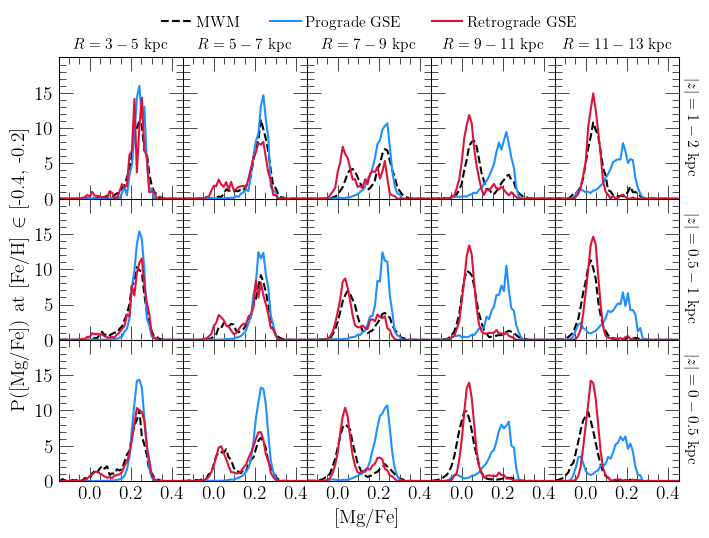

In [5]:
# COLORS = ["black", "dodgerblue", "crimson"]
COLORS = ["dodgerblue", "crimson"]
RADII = [[3, 5], [5, 7], [7, 9], [9, 11], [11, 13]]
ZHEIGHTS = [[1, 2], [0.5, 1], [0, 0.5]] # backwards to put high |z| at the top
# LABELS = ["No Burst", r"$\beta_{\phi,\text{GSE}} = +0.8$", r"$\beta_{\phi,\text{GSE}} = -0.8$"]
# LABELS = [r"$\beta_{\phi,\text{GSE}} = +0.8$", r"$\beta_{\phi,\text{GSE}} = -0.8$"]
LABELS = ["Prograde GSE", "Retrograde GSE"]
FEH_ERR = 0.0087
MGFE_ERR = 0.017
FEH_MIN = -0.4
FEH_MAX = -0.2

fig, axes = plt.subplots(nrows = len(ZHEIGHTS), ncols = len(RADII), figsize = (8, 5.5), sharex = True, sharey = True)
axes[0][0].set_xlim([-0.15, 0.45])
axes[0][0].set_ylim([0, 20])
axes[0][0].set_xticks([0, 0.2, 0.4])
axes[0][0].set_yticks([0, 5, 10, 15])
axes[2][2].set_xlabel(r"[Mg/Fe]")
axes[1][0].set_ylabel(r"P([Mg/Fe]) at [Fe/H] $\in$ [%g, %g]" % (FEH_MIN, FEH_MAX))
for i in range(len(RADII)):
    axes[0][i].set_title(r"$R = %d - %d$ kpc" % (RADII[i][0], RADII[i][1]), fontsize = 11)
for i in range(len(ZHEIGHTS)):
    axes[i][-1].yaxis.set_label_position("right")
    axes[i][-1].set_ylabel(r"$\left|z\right| = %g - %g$ kpc" % (ZHEIGHTS[i][0], ZHEIGHTS[i][1]),
        fontsize = 11, rotation = 270, labelpad = 15)

def plot_distributions(ax, output, rmin, rmax, abszmin, abszmax, fehmin, fehmax, zone_width = 0.1, **kwargs):
    stars = output.stars.filter(
        "zone_final", ">=", int(rmin / zone_width)).filter(
        "zone_final", "<=", int(rmax / zone_width) - 1).filter(
        "absz", ">=", abszmin).filter(
        "absz", "<=", abszmax).filter(
        "[fe/h]", ">=", fehmin).filter(
        "[fe/h]", "<=", fehmax).filter(
        "mass", ">=", 1)
    err_feh = np.random.normal(scale = FEH_ERR, size = len(stars["mass"]))
    err_mgfe = np.random.normal(scale = MGFE_ERR, size = len(stars["mass"]))
    for i in range(len(stars["mass"])):
        stars["[fe/h]"][i] += err_feh[i]
        stars["[mg/fe]"][i] += err_mgfe[i]
    hist, bins = np.histogram(stars["[mg/fe]"], bins = 50, range = ax.get_xlim(),
        weights = stars["mass"], density = True)
    xvals = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    ax.plot(xvals, hist, **kwargs)

# def plot_observed_distributions(ax, rmin, abszmin, fehmin, **kwargs):
    # path = "../data/ofe_mdfs/Rmin%.1f_hmin%.1f_FeHmin%.1f.dat" % (rmin, abszmin, fehmin)
    # raw = np.genfromtxt(path)
    # ofe = raw[:,-2]
    # p_ofe = raw[:,-1]
    # dofe = ofe[1] - ofe[0]
    # norm = 0
    # for i in range(len(ofe)):
    #     norm += p_ofe[i] * dofe
    # p_ofe = [p / norm for p in p_ofe]
    # ax.plot(ofe, p_ofe, **kwargs)

def plot_observed_distributions(ax, rmin, rmax, abszmin, abszmax, fehmin, fehmax, **kwargs):
    # stars = IPL3_GIANTS.filter(
    stars = DR19GIANTS.filter(
        "rgal", ">=", rmin).filter(
        "rgal", "<=", rmax).filter(
        "absz", ">=", abszmin).filter(
        "absz", "<=", abszmax).filter(
        "fe_h", ">=", fehmin).filter(
        "fe_h", "<=", fehmax).filter(
        "mg_fe", ">=", ax.get_xlim()[0]).filter(
        "mg_fe", "<=", ax.get_xlim()[1])
    hist, bins = np.histogram(stars["mg_fe"], bins = 50, range = ax.get_xlim(), density = True)
    xvals = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    ax.plot(xvals, hist, **kwargs)

for j in range(len(RADII)):
    for k in range(len(ZHEIGHTS)):
        kwargs = {
            "c": named_colors()["black"],
            "linestyle": "--",
            "label": "MWM"
        }
        plot_observed_distributions(axes[k][j], *RADII[j], *ZHEIGHTS[k], FEH_MIN, FEH_MAX, **kwargs)

for i in range(len(outputs)):
    for j in range(len(RADII)):
        for k in range(len(ZHEIGHTS)):
            kwargs = {
                "c": named_colors()[COLORS[i]],
                "label": LABELS[i]
            }
            plot_distributions(axes[k][j], outputs[i], *RADII[j], *ZHEIGHTS[k], FEH_MIN, FEH_MAX, **kwargs)

# axes[0][3].text(0.2, 1.25 * axes[0][0].get_ylim()[1], r"[Fe/H] $\in$ [%g, %g]" % (FEH_MIN, FEH_MAX), fontsize = 11)
# axes[0][2].text(axes[0][2].get_xlim()[0], 1.4 * axes[0][2].get_ylim()[1],
#     r"[Fe/H] $\in$ [%g, %g]" % (FEH_MIN, FEH_MAX), fontsize = 11)

kwargs = {
    "loc": mpl_loc("lower center"),
    "bbox_to_anchor": (0.5, 1.1),
    "ncol": 4,
    "handlelength": 2,
    "fontsize": 11
}
leg = axes[0][2].legend(**kwargs)
# fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./afe-feh/galactic-regions-dists-prograde-vs-retrograde-vs-data.%s" % (ext), **kwargs)
plt.show()

In [39]:
# noburst = vice.output("../outputs/expifr/amd_betaphiin0p8")
# burst = vice.output("../outputs/expifr_gse/massratio3-tacc3p2-gsechem")
# burst_zpoor = vice.output("../outputs/expifr_gse/massratio3-tacc3p2-metalpoorgse")
# burst_zpoor_expsigma = vice.output("../outputs/expifr_gse/massratio3-tacc3p2-metalpoorgse-expsigma")


# noburst = vice.output("../outputs/expifr/amd_betaphiin0p8-sigmacrit1e6")
# burst = vice.output("../outputs/expifr_gse/amd_betaphiin0p8-sigmacrit1e6-massratio3")
# burst_radial = vice.output("../outputs/expifr_gse/amd_betaphiin0p8-sigmacrit1e6-massratio3-gsebetaphiin0")
# burst_retro = vice.output("../outputs/expifr_gse/amd_betaphiin0p8-sigmacrit1e6-massratio3-gsebetaphiin-1")
# burst_retro_metalpoorgse = vice.output("../outputs/expifr_gse/amd_betaphiin0p8-sigmacrit1e6-massratio3-gsebetaphiin-1-metalpoor")
# burst_retro_metalpoorgse_highmass = vice.output("../outputs/expifr_gse/amd_betaphiin0p8-sigmacrit1e6-massratio1-gsebetaphiin-1-metalpoor")

# smooth = vice.output("../outputs/expifr/amd_betaphiin0p8-sigmacrit1e6")
# diskcollapse = vice.output("../outputs/expifr/amd_betaphiin0p8-diskcollapsetest")
# # diskcollapse_gse = vice.output("../outputs/expifr_gse/amd_betaphiin0p8-diskcollapse-gse5p2Gyr-massive-zpoor")
# # diskcollapse_gse = vice.output("../outputs/expifr_gse/amd_betaphiin0p8-diskcollapse-gse5p2Gyr-massive")
# diskcollapse_gse = vice.output("../outputs/expifr_gse/amd_betaphiin0p8-diskcollapse-gse7p2Gyr-massive-zpoor")
# diskcollapse_gse_prograde = vice.output("../outputs/expifr_gse/amd_betaphiin0p8-diskcollapse-gse7p2Gyr-massive-zpoor-prograde")
# output = vice.output("../outputs/expifr/amd/betaphiin0p8")

output = vice.output("../outputs/expifr/amd-pwd/base")
comp = vice.output("../outputs/expifr_gse/amd-pwd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8")
comp2 = vice.output("../outputs/expifr_gse/amd-pwd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p2")
amd = vice.output("../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8")

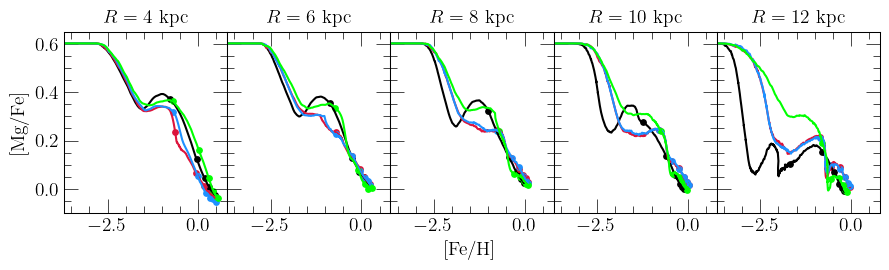

In [40]:
RADII = [4, 6, 8, 10, 12]

fig = plt.figure(figsize = (9, 2.8))
axes = []
for i in range(5):
    axes.append(fig.add_subplot(151 + i))
    axes[i].set_xlim([-3.7, 0.8])
    axes[i].set_ylim([-0.1, 0.65])
    axes[i].set_title(r"$R = %d$ kpc" % (RADII[i]))
    if i: plt.setp(axes[i].get_yticklabels(), visible = False)
    # axes[i].set_xticks([-2, -1, 0])
axes[2].set_xlabel(r"[Fe/H]")
axes[0].set_ylabel(r"[Mg/Fe]")

def plot_track(ax, output, radius, marklookbacks = [], zone_width = 0.1, **kwargs):
    zone = int(radius / zone_width)
    zone = output.zones["zone%d" % (zone)]
    ax.plot(zone.history["[fe/h]"], zone.history["[mg/fe]"], **kwargs)
    for i in range(len(marklookbacks)):
        diff = [abs(_ - marklookbacks[i]) for _ in zone.history["lookback"]]
        idx = diff.index(min(diff))
        _kwargs = {}
        if "c" in kwargs.keys(): _kwargs["color"] = kwargs["c"]
        _kwargs["marker"] = markers()["circle"]
        _kwargs["s"] = 15
        ax.scatter(zone.history["[fe/h]"][idx], zone.history["[mg/fe]"][idx], **_kwargs)
    
for i in range(len(RADII)):
    plot_track(axes[i], output, RADII[i], marklookbacks = [0, 2, 4, 6, 8, 10], c = named_colors()["black"])
    plot_track(axes[i], comp, RADII[i], marklookbacks = [0, 2, 4, 6, 8, 10], c = named_colors()["crimson"])
    plot_track(axes[i], comp2, RADII[i], marklookbacks = [0, 2, 4, 6, 8, 10], c = named_colors()["dodgerblue"])
    plot_track(axes[i], amd, RADII[i], marklookbacks = [0, 2, 4, 6, 8, 10], c = named_colors()["lime"])
    # plot_track(axes[i], smooth, RADII[i], marklookbacks = [0, 2, 4, 6, 8, 10], c = named_colors()["black"])
    # plot_track(axes[i], diskcollapse, RADII[i], marklookbacks = [0, 2, 4, 6, 8, 10], c = named_colors()["crimson"])
    # plot_track(axes[i], diskcollapse_gse, RADII[i], marklookbacks = [0, 2, 4, 6, 8, 10], c = named_colors()["dodgerblue"])
    # plot_track(axes[i], diskcollapse_gse_prograde, RADII[i], marklookbacks = [0, 2, 4, 6, 8, 10], c = named_colors()["lime"])
    # plot_track(axes[i], noburst, RADII[i], marklookbacks = [0, 2, 4, 6, 8, 10], c = named_colors()["black"], label = "No Burst")
    # plot_track(axes[i], burst, RADII[i], marklookbacks = [0, 2, 4, 6, 8, 10], c = named_colors()["crimson"], label = "Burst")
    # plot_track(axes[i], burst_radial, RADII[i], marklookbacks = [0, 2, 4, 6, 8, 10],
    #     c = named_colors()["dodgerblue"], label = "Burst (Radial)")
    # plot_track(axes[i], burst_retro, RADII[i], marklookbacks = [0, 2, 4, 6, 8, 10],
    #     c = named_colors()["lime"], label = "Burst (Retrograde)")
    # plot_track(axes[i], burst_retro_metalpoorgse, RADII[i], marklookbacks = [0, 2, 4, 6, 8, 10],
    #     c = named_colors()["crimson"], label = "Burst (Retrograde \& Metal-Poor)")
    # plot_track(axes[i], burst_retro_metalpoorgse_highmass, RADII[i], marklookbacks = [0, 2, 4, 6, 8, 10],
    #     c = named_colors()["gold"], label = "Burst (Retrograde \& Metal-Poor)")
    # plot_track(axes[i], burst, RADII[i], marklookbacks = [0, 2, 4, 6, 8, 10], c = named_colors()["crimson"], label = "Burst")
    # plot_track(axes[i], burst_zpoor, RADII[i], marklookbacks = [0, 2, 4, 6, 8, 10],
    #     c = named_colors()["dodgerblue"], label = "Burst (Z-poor GSE)")
    # plot_track(axes[i], burst_zpoor, RADII[i], marklookbacks = [0, 2, 4, 6, 8, 10],
    #     c = named_colors()["dodgerblue"], label = "Burst (Z-poor GSE)")
    # plot_track(axes[i], burst_zpoor_expsigma, RADII[i], marklookbacks = [0, 2, 4, 6, 8, 10],
    #     c = named_colors()["lime"], label = "Burst (Z-poor GSE)")

plt.tight_layout()
plt.subplots_adjust(wspace = 0)
plt.show()

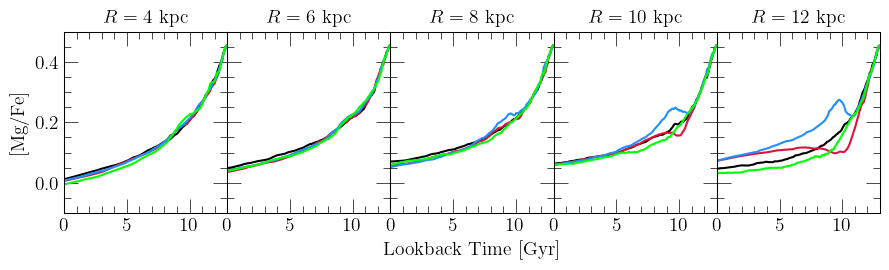

In [17]:
RADII = [4, 6, 8, 10, 12]

fig = plt.figure(figsize = (9, 2.8))
axes = []
for i in range(5):
    axes.append(fig.add_subplot(151 + i))
    axes[i].set_xlim([0.0, 13])
    axes[i].set_ylim([-0.1, 0.5])
    axes[i].set_title(r"$R = %d$ kpc" % (RADII[i]))
    if i: plt.setp(axes[i].get_yticklabels(), visible = False)
    # axes[i].set_xscale("log")
    axes[i].set_xticks([0, 5, 10])
axes[2].set_xlabel(r"Lookback Time [Gyr]")
axes[0].set_ylabel(r"[Mg/Fe]")

def plot_evol(ax, output, radius, zone_width = 0.1, **kwargs):
    zone = int(radius / zone_width)
    zone = output.zones["zone%d" % (zone)]
    ax.plot(zone.history["lookback"], zone.history["[mg/fe]"], **kwargs)

for i in range(len(RADII)):
    plot_evol(axes[i], noburst, RADII[i], c = named_colors()["black"], label = "No Burst")
    plot_evol(axes[i], burst, RADII[i], c = named_colors()["crimson"], label = "Burst")
    plot_evol(axes[i], burst_zpoor, RADII[i], c = named_colors()["dodgerblue"], label = "Burst")
    plot_evol(axes[i], burst_zpoor_expsigma, RADII[i], c = named_colors()["lime"], label = "Burst")

plt.tight_layout()
plt.subplots_adjust(wspace = 0)
plt.show()

In [2]:
# name = "../outputs/expifr/amd_betaphiin0p8"
# name = "../outputs/expifr_gse/massratio3-tacc3p2-gsechem"
# name = "../outputs/expifr_gse/massratio3-tacc3p2-metalpoorgse"
# name = "../outputs/expifr_gse/massratio3-tacc3p2-metalpoorgse-expsigma"
# name = "../outputs/expifr/amd_betaphiin0p8-sigmacrit1e6"
# name = "../outputs/expifr_gse/amd_betaphiin0p8-sigmacrit1e6-massratio3"
# name = "../outputs/expifr_gse/amd_betaphiin0p8-sigmacrit1e6-massratio3-gsebetaphiin0"
# name = "../outputs/expifr_gse/amd_betaphiin0p8-sigmacrit1e6-massratio3-gsebetaphiin-1"
# name = "../outputs/expifr_gse/amd_betaphiin0p8-sigmacrit1e6-massratio3-gsebetaphiin-1-metalpoor"
# name = "../outputs/expifr_gse/amd_betaphiin0p8-sigmacrit1e6-massratio1-gsebetaphiin-1-metalpoor"
# name = "../outputs/expifr/amd_betaphiin0p8-diskcollapsetest"
# name = "../outputs/expifr_gse/amd_betaphiin0p8-diskcollapse-gse5p2Gyr-massive-zpoor"
# name = "../outputs/expifr_gse/amd_betaphiin0p8-diskcollapse-gse7p2Gyr-massive"
# name = "../outputs/expifr_gse/amd_betaphiin0p8-diskcollapse-gse7p2Gyr-massive-zpoor"
# name = "../outputs/expifr_gse/amd_betaphiin0p8-diskcollapse-gse7p2Gyr-massive-zpoor-prograde"


# name = "../outputs/expifr/amd-pwd/base"
name = "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8"
output = vice.output(name)
extra = np.genfromtxt("%s_analogdata.out" % (output.name))
output.stars["absz"] = [abs(_) for _ in extra[:,-1][:output.stars.size[0]]]

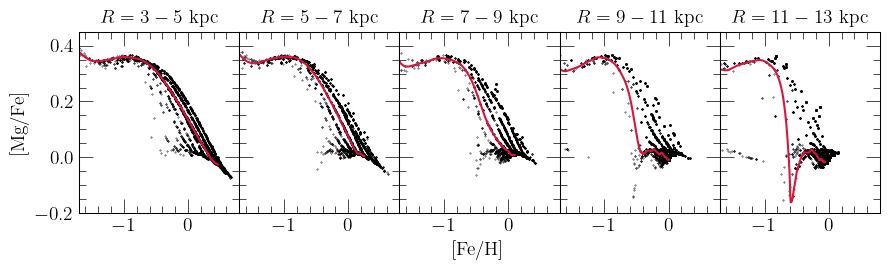

In [3]:
RADIAL_BINS = [[3, 5], [5, 7], [7, 9], [9, 11], [11, 13]]

fig = plt.figure(figsize = (9, 2.8))
axes = []
for i in range(5):
    axes.append(fig.add_subplot(151 + i))
    axes[i].set_xlim([-1.7, 0.8])
    axes[i].set_ylim([-0.2, 0.45])
    axes[i].set_title(r"$R = %d - %d$ kpc" % (RADIAL_BINS[i][0], RADIAL_BINS[i][1]))
    if i: plt.setp(axes[i].get_yticklabels(), visible = False)
    # axes[i].set_xticks([-2, -1, 0])
axes[2].set_xlabel(r"[Fe/H]")
axes[0].set_ylabel(r"[Mg/Fe]")

def plot_stars(ax, output, rmin, rmax, abszmin, abszmax, zone_width = 0.1, N = 5000, seed = 0, **kwargs):
    stars = output.stars.filter(
        "zone_final", ">=", int(rmin / zone_width)).filter(
        "zone_final", "<=", int(rmax / zone_width) - 1).filter(
        "absz", ">=", abszmin).filter(
        "absz", "<=", abszmax).filter(
        "mass", ">=", 1)
    stars = subsample_stellar_populations(stars, N = N, seed = seed)
    ax.scatter(stars["[fe/h]"], stars["[mg/fe]"], **kwargs)

def plot_track(ax, output, radius, zone_width = 0.1, **kwargs):
    zone = int(radius / zone_width)
    zone = output.zones["zone%d" % (zone)]
    ax.plot(zone.history["[fe/h]"], zone.history["[mg/fe]"], **kwargs)

for i in range(len(RADIAL_BINS)):
# for i in [0]:
    kwargs = {
        "color": named_colors()["black"],
        "s": 0.1,
        "rasterized": True
    }
    # plot_stars(axes[i], output, RADIAL_BINS[i][0], RADIAL_BINS[i][1], 0, 0.5, **kwargs)
    plot_stars(axes[i], output, RADIAL_BINS[i][0], RADIAL_BINS[i][1], 0, 0.5, zone_width = 1, **kwargs)
    kwargs = {"c": named_colors()["crimson"]}
    # plot_track(axes[i], output, sum(RADIAL_BINS[i]) / 2, **kwargs)
    plot_track(axes[i], output, sum(RADIAL_BINS[i]) / 2, zone_width = 1, **kwargs)
    

plt.tight_layout()
plt.subplots_adjust(wspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    # plt.savefig("./afe-feh/basemodel-scatterplot.%s" % (ext), **kwargs)
    # plt.savefig("./afe-feh/tacc3p2-prograde-scatterplot.%s" % (ext), **kwargs)
    # plt.savefig("./afe-feh/tacc3p2-radial-scatterplot.%s" % (ext), **kwargs)
    # plt.savefig("./afe-feh/tacc9p2-retrograde-scatterplot.%s" % (ext), **kwargs)
plt.show()

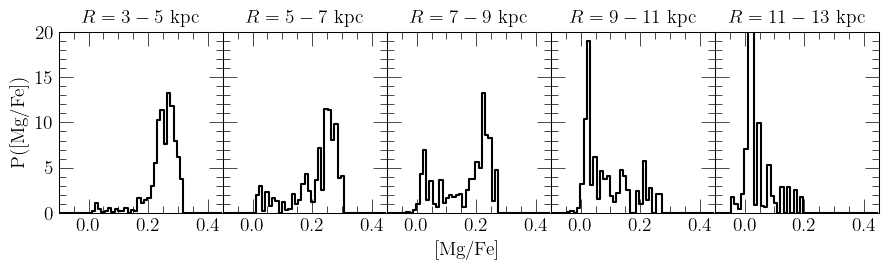

In [6]:
RADIAL_BINS = [[3, 5], [5, 7], [7, 9], [9, 11], [11, 13]]

fig = plt.figure(figsize = (9, 2.8))
axes = []
for i in range(5):
    axes.append(fig.add_subplot(151 + i))
    axes[i].set_xlim([-0.1, 0.45])
    axes[i].set_ylim([0, 20])
    axes[i].set_title(r"$R = %d - %d$ kpc" % (RADIAL_BINS[i][0], RADIAL_BINS[i][1]))
    if i: plt.setp(axes[i].get_yticklabels(), visible = False)
    # axes[i].set_xticks([-2, -1, 0])
    axes[i].set_xticks([0, 0.2, 0.4])
axes[2].set_xlabel(r"[Mg/Fe]")
axes[0].set_ylabel(r"P([Mg/Fe])")

def plot_distribution(ax, output, rmin, rmax, abszmin, abszmax, fehmin, fehmax, zone_width = 0.1, **kwargs):
    stars = output.stars.filter(
        "zone_final", ">=", int(rmin / zone_width)).filter(
        "zone_final", "<=", int(rmax / zone_width) - 1).filter(
        "absz", ">=", abszmin).filter(
        "absz", "<=", abszmax).filter(
        "[fe/h]", ">=", fehmin).filter(
        "[fe/h]", "<=", fehmax).filter(
        "mass", ">=", 1)
    hist, bins = np.histogram(stars["[mg/fe]"], bins = 50, range = ax.get_xlim(),
        weights = stars["mass"], density = True)
    xvals = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    ax.plot(xvals, hist, **kwargs)

for i in range(len(RADIAL_BINS)):
    kwargs = {
        "c": named_colors()["black"],
        "drawstyle": "steps-mid"
    }
    # plot_distribution(axes[i], output, RADIAL_BINS[i][0], RADIAL_BINS[i][1], 0, 0.5, -0.4, -0.2, **kwargs)
    plot_distribution(axes[i], output, RADIAL_BINS[i][0], RADIAL_BINS[i][1], 0, 1, -0.4, -0.2, zone_width = 1, **kwargs)

plt.tight_layout()
plt.subplots_adjust(wspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    # plt.savefig("./afe-feh/basemodel-afedists.%s" % (ext), **kwargs)
    # plt.savefig("./afe-feh/tacc3p2-prograde-afedists.%s" % (ext), **kwargs)
    # plt.savefig("./afe-feh/tacc3p2-radial-afedists.%s" % (ext), **kwargs)
    # plt.savefig("./afe-feh/tacc9p2-retrograde-afedists.%s" % (ext), **kwargs)
plt.show()